In [66]:
from modules.feature_selector import (
    a_to_e_base_features,
    get_required_base_columns_for_derived_features,
    generate_common_derived_features
)
from modules.preprocess_utils import map_categorical_columns
from modules.feature_selector import generate_rfm_features_original, rfm_base_columns, rfm_feature_cols, abcd_final_features, cd_baseline
import pandas as pd

# ✅ 파일 경로
file_path = "../../data/통합_train_데이터.parquet"


# ✅ 전체 불러올 컬럼 조합
base_cols = ["ID", "Segment"]
required_cols = get_required_base_columns_for_derived_features()
train_cols = sorted(set(base_cols + a_to_e_base_features + cd_baseline + required_cols + rfm_base_columns))
train_df = pd.read_parquet(file_path, columns=train_cols)             # 데이터 로드

# ✅ 데이터 불러오기 + 전처리 파이프라인
train_df = map_categorical_columns(train_df)                          # 범주형 인코딩
train_df = generate_rfm_features_original(train_df)                   # RFM 변수 및 세그먼트 생성
train_df = generate_common_derived_features(train_df)                 # 파생변수 생성

final_features = base_cols + list(set(abcd_final_features + rfm_feature_cols)) # 최종선별 피처

[연회비발생카드수_B0M] 인코딩 완료
[한도증액횟수_R12M] 인코딩 완료
[이용금액대] 중간값 인코딩 완료
[할인건수_R3M] 인코딩 완료
[할인건수_B0M] 인코딩 완료
✔️ RFM 파생변수 생성 완료
=== RFM 변수 요약 ===

-- Recency 통계 --
count    2.400000e+06
mean     7.360273e+01
std      7.241042e+01
min      2.000000e+00
25%      1.700000e+01
50%      5.100000e+01
75%      1.040000e+02
max      3.370000e+02
Name: Recency, dtype: float64
값 분포:
Recency
2       52023
3       55969
4       59968
5       64069
6      119886
        ...  
333         1
334         1
335         1
336         1
337         2
Name: count, Length: 335, dtype: int64

-- Frequency 통계 --
count    2.400000e+06
mean     1.086286e+02
std      1.343633e+02
min      0.000000e+00
25%      5.000000e+00
50%      5.100000e+01
75%      1.660000e+02
max      8.620000e+02
Name: Frequency, dtype: float64
값 분포:
Frequency
0      451477
1       38305
2       34133
3       30755
4       27743
        ...  
853         1
854         1
856         2
861         1
862         2
Name: count, Length: 850, dtype: int6

In [67]:
df = train_df[final_features]

In [68]:
# ✅ 전체 컬럼 수 및 미리보기
print(f"총 컬럼 수: {len(df.columns)}개")
print("\n📌 전체 컬럼 목록:")
print(df.columns.tolist())

# ✅ 결측치 요약
print("\n🔍 결측치 개수:")
print(df.isnull().sum().sort_values(ascending=False))

# ✅ 데이터 타입 요약
print("\n📊 데이터 타입 요약:")
print(df.dtypes.value_counts())

총 컬럼 수: 121개

📌 전체 컬럼 목록:
['ID', 'Segment', 'F_score', '_1순위업종_이용금액', 'M_score', '평잔_CA_3M', '상향가능CA한도금액', '정상청구원금_B0M', '청구금액_R3M', '인입일수_ARS_B0M', '이용후경과월_체크', '할인비율_R3M', '혜택수혜금액_R3M', '신판CA_평균소진율_비중', '평잔_일시불_해외_6M', '이용건수_선결제_R6M', 'Monetary', '홈페이지_금융건수_R6M', '월상환론상향가능한도금액', '청구서발송여부_R6M', '변동률_할부평잔', '이용금액_해외', '이용건수_A페이_R6M', 'Recency', '증감율_이용건수_체크_전월', '이용카드수_신용체크', '당사멤버쉽_방문횟수_R6M', 'RFM_segment', '일시상환론한도금액', '월상환론한도금액', '청구서발송여부_B0', '거주시도명', '최대이용금액_일시불_R12M', '교통_주유이용금액', '할인건수_R3M', '정상입금_증감률_B0M_B5M', '회원여부_연체', '연속유실적개월수_기본_24M_카드', 'R_score', 'RP후경과월', '컨택건수_신용발급_TM_R6M', '남녀구분코드', '할인건수_B0M', '카드론이용금액_누적', '카드이용한도금액', '신용체크_이용비율_R3M', '증감율_이용금액_체크_분기', '정상청구원금_증감률_B5M_B2M', '동의여부_한도증액안내', '컨택건수_이용유도_LMS_R6M', '일시불_이용비중', '이용금액_일시불_B0M', '이용금액_선결제비율', '쇼핑_온라인_이용금액', '잔액_일시불_B0M', '여유_숙박이용금액', '이용금액_선결제_R6M', '이용건수_D페이_R6M', '정상청구원금_단기증감률', '연회비발생카드수_B0M', 'RFM_score', '카드론_잔액_B0M_증가율', '탈회횟수_누적', '연체감액여부_R3M', '이용금액_할부_무이자_R3M', '탈회횟수_발급1년이내', '정상청구원금_입금비중_B5M', 'RV_

In [69]:
# 📌 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

# 📌 1. 데이터 전처리
X = df.drop(columns=["ID", "Segment"]).copy()
y = df["Segment"]

# 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 타겟 인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 📌 2. Optuna로 하이퍼파라미터 튜닝 (3-Fold 교차검증 기준)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 180, 650),
        'max_depth': trial.suggest_int('max_depth', 7, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'device' : 'cuda',
        'predictor': 'gpu_predictor',
        'eval_metric': 'mlogloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)

    # 간단한 평가 (K-Fold 없이 전체에서 cross_val)
    score = cross_val_score(model, X_scaled, y_encoded, cv=3, scoring='f1_weighted')
    return score.mean()

#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=50)  # ✅ 컴퓨터 리소스 고려해서 50회만

best_params = {
    'n_estimators': 321,
    'max_depth': 10,
    'learning_rate': 0.09548408810497082,
    'subsample': 0.8556876429639826,
    'colsample_bytree': 0.7782984753015704
}

# 최적 파라미터 확인
#best_params = study.best_params
print("\n✅ 최적 하이퍼파라미터:")
for k, v in best_params.items():
    print(f"{k}: {v}")


✅ 최적 하이퍼파라미터:
n_estimators: 321
max_depth: 10
learning_rate: 0.09548408810497082
subsample: 0.8556876429639826
colsample_bytree: 0.7782984753015704


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# 준비된 데이터: X_scaled, y_encoded, le_y, df_raw (← 반드시 ID 포함한 원본)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
ros = RandomOverSampler(sampling_strategy={0: 2000, 1: 2000}, random_state=42)

fold = 1
all_reports = []
df_oof_list = []

for train_idx, val_idx in skf.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    X_train_os, y_train_os = ros.fit_resample(X_train, y_train)
    print(f"\n🔁 Fold {fold} 오버샘플링 완료:", pd.Series(y_train_os).value_counts().to_dict())

    xgb_model = XGBClassifier(
        **best_params,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        eval_metric='mlogloss',
        random_state=42
    )
    xgb_model.fit(X_train_os, y_train_os)

    # 예측
    y_pred = xgb_model.predict(X_val)
    y_proba = xgb_model.predict_proba(X_val)

    print(f"\n📘 Fold {fold} 결과")
    print(classification_report(y_val, y_pred, target_names=le_y.classes_))
    all_reports.append(classification_report(y_val, y_pred, output_dict=True))

    df_val = X_val.copy()
    df_val["ID"] = df.iloc[val_idx]["ID"].values
    df_val["Segment_true"] = le_y.inverse_transform(y_val)
    df_val["Segment_pred"] = le_y.inverse_transform(y_pred)
    df_val["probs_ae"] = list(y_proba)

    # ✅ 핵심: CD 모델 학습용 인덱스 저장
    df_val["original_index"] = val_idx
    fold += 1
    df_oof_list.append(df_val)
# ✅ 전체 OOF 통합
df_oof = pd.concat(df_oof_list, axis=0).reset_index(drop=True)
print("\n✅ 전체 OOF 결과 저장 완료 → df_oof")



🔁 Fold 1 오버샘플링 완료: {4: 1281368, 3: 232828, 2: 85060, 0: 2000, 1: 2000}

📘 Fold 1 결과
              precision    recall  f1-score   support

           A       0.91      0.64      0.75       324
           B       0.94      0.67      0.78        48
           C       0.84      0.70      0.77     42530
           D       0.79      0.72      0.75    116414
           E       0.95      0.98      0.96    640684

    accuracy                           0.92    800000
   macro avg       0.89      0.74      0.80    800000
weighted avg       0.92      0.92      0.92    800000


🔁 Fold 2 오버샘플링 완료: {4: 1281368, 3: 232828, 2: 85060, 0: 2000, 1: 2000}

📘 Fold 2 결과
              precision    recall  f1-score   support

           A       0.97      0.66      0.78       324
           B       0.92      0.48      0.63        48
           C       0.84      0.70      0.77     42530
           D       0.79      0.72      0.75    116414
           E       0.95      0.98      0.96    640684

    accuracy   

ValueError: No objects to concatenate

In [71]:
# 1. 기본 정보 확인
print("📌 df_oof shape:", df_oof.shape)
print("\n📌 df_oof columns:", df_oof.columns.tolist())

# 2. 상위 5개 행 미리보기
display(df_oof.head())

# 3. Segment 예측 vs 실제 값 비교 (빈도)
print("\n📊 Segment 예측 결과 분포:")
print("True:")
print(df_oof["Segment_true"].value_counts())
print("\nPred:")
print(df_oof["Segment_pred"].value_counts())

# 4. 예측 확률 확인 (클래스별 확률 구조)
print("\n🔍 예측 확률 확인 (probs_ae 열 샘플):")
print(df_oof["probs_ae"].apply(lambda x: np.round(x, 3)).head())


📌 df_oof shape: (2400000, 123)

📌 df_oof columns: ['F_score', '_1순위업종_이용금액', 'M_score', '평잔_CA_3M', '상향가능CA한도금액', '정상청구원금_B0M', '청구금액_R3M', '인입일수_ARS_B0M', '이용후경과월_체크', '할인비율_R3M', '혜택수혜금액_R3M', '신판CA_평균소진율_비중', '평잔_일시불_해외_6M', '이용건수_선결제_R6M', 'Monetary', '홈페이지_금융건수_R6M', '월상환론상향가능한도금액', '청구서발송여부_R6M', '변동률_할부평잔', '이용금액_해외', '이용건수_A페이_R6M', 'Recency', '증감율_이용건수_체크_전월', '이용카드수_신용체크', '당사멤버쉽_방문횟수_R6M', 'RFM_segment', '일시상환론한도금액', '월상환론한도금액', '청구서발송여부_B0', '거주시도명', '최대이용금액_일시불_R12M', '교통_주유이용금액', '할인건수_R3M', '정상입금_증감률_B0M_B5M', '회원여부_연체', '연속유실적개월수_기본_24M_카드', 'R_score', 'RP후경과월', '컨택건수_신용발급_TM_R6M', '남녀구분코드', '할인건수_B0M', '카드론이용금액_누적', '카드이용한도금액', '신용체크_이용비율_R3M', '증감율_이용금액_체크_분기', '정상청구원금_증감률_B5M_B2M', '동의여부_한도증액안내', '컨택건수_이용유도_LMS_R6M', '일시불_이용비중', '이용금액_일시불_B0M', '이용금액_선결제비율', '쇼핑_온라인_이용금액', '잔액_일시불_B0M', '여유_숙박이용금액', '이용금액_선결제_R6M', '이용건수_D페이_R6M', '정상청구원금_단기증감률', '연회비발생카드수_B0M', 'RFM_score', '카드론_잔액_B0M_증가율', '탈회횟수_누적', '연체감액여부_R3M', '이용금액_할부_무이자_R3M', '탈회횟수_발급1년이내', '정상청구원금_입금비중_B5M

,F_score,_1순위업종_이용금액,M_score,평잔_CA_3M,상향가능CA한도금액,정상청구원금_B0M,청구금액_R3M,인입일수_ARS_B0M,이용후경과월_체크,할인비율_R3M,...,포인트_이용포인트_R12M,회원여부_이용가능_카드론,정상청구원금_청구비중_B5M,RP건수_통신_B0M,이용건수_C페이_R6M,증감율_이용건수_할부_전월,ID,Segment_true,Segment_pred,probs_ae
0,0.449666,-0.362962,-0.447184,-0.172013,0.116400,0.152279,-0.220539,-0.246912,0.450672,-0.154386,...,-0.206026,0.780704,-0.212619,-0.544655,-0.126829,0.168835,TRAIN_000001,E,E,"[1.37833585e-08, 1.5252219e-08, 2.2717584e-05,..."
1,-0.442690,-0.392895,-0.447184,-0.172013,-0.954675,-0.575448,-0.375537,-0.246912,0.450672,-0.154386,...,-0.144609,0.780704,-0.212619,1.113149,-0.126829,0.168835,TRAIN_000011,D,D,"[6.932194e-08, 7.2273814e-08, 0.0081128515, 0...."
2,0.449666,-0.455811,-0.447184,-0.172013,1.187474,-0.516414,-0.389242,-0.246912,0.450672,-0.154386,...,2.666355,0.780704,-0.212619,1.113149,-0.126829,0.168835,TRAIN_000020,E,E,"[5.7868277e-08, 6.689256e-08, 0.00036703006, 0..."
3,-0.442690,0.546214,-0.447184,-0.172013,0.116400,-0.330966,-0.271668,-0.246912,0.450672,-0.154386,...,-0.206026,0.780704,-0.212619,1.113149,-0.126829,0.168835,TRAIN_000023,E,E,"[3.9868686e-09, 4.829801e-09, 2.4374624e-06, 2..."
4,1.342023,0.260776,1.341648,0.078470,-0.954675,1.532164,0.150470,4.481828,-2.417150,-0.154386,...,-0.206026,-1.280896,-0.212619,-0.544655,-0.126829,-0.962719,TRAIN_000025,D,D,"[6.077066e-07, 7.608622e-07, 0.13134447, 0.787..."



📊 Segment 예측 결과 분포:
True:
Segment_true
E    1922052
D     349242
C     127590
A        972
B        144
Name: count, dtype: int64

Pred:
Segment_pred
E    1971390
D     320927
C     106922
A        668
B         93
Name: count, dtype: int64

🔍 예측 확률 확인 (probs_ae 열 샘플):

Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

0          [0.0, 0.0, 0.0, 0.0, 1.0]
1    [0.0, 0.0, 0.008, 0.958, 0.033]
2      [0.0, 0.0, 0.0, 0.002, 0.997]
3          [0.0, 0.0, 0.0, 0.0, 1.0]
4    [0.0, 0.0, 0.131, 0.788, 0.081]
Name: probs_ae, dtype: object


In [8]:
# 예측 수행
y_pred = xgb_model.predict(X_scaled)  # 전체 학습 데이터 기준
y_true = y_encoded                      # 원본 라벨 (인코딩된 값)

In [81]:
df_val = X_scaled.iloc[val_idx].copy()

# ✅ A~E 예측 결과 + 정답
df_val["ID"] = df.iloc[val_idx]["ID"].values
df_val["Segment_true"] = le_y.inverse_transform(y_val)
df_val["Segment_pred"] = le_y.inverse_transform(y_pred)
df_val["probs_ae"] = list(y_proba)

# ✅ 🎯 CD 재학습을 위한 핵심 포인트
df_val["original_index"] = val_idx  # 👈 반드시 필요

c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


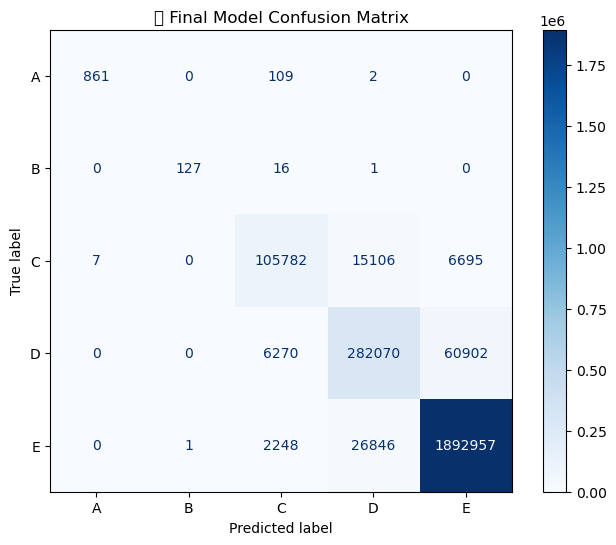

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_y.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Final Model Confusion Matrix")
plt.show()

In [10]:
# Pandas DataFrame으로 보기 좋게 출력
cm_df = pd.DataFrame(cm, index=le_y.classes_, columns=le_y.classes_)
print("📘 Confusion Matrix (A~E):")
display(cm_df)

📘 Confusion Matrix (A~E):


,A,B,C,D,E
A,861,0,109,2,0
B,0,127,16,1,0
C,7,0,105782,15106,6695
D,0,0,6270,282070,60902
E,0,1,2248,26846,1892957


c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


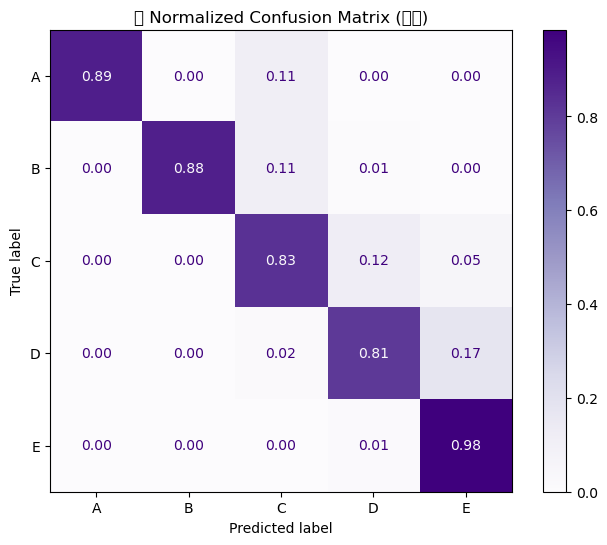

In [11]:
# 비율 기준 혼동 행렬 (정규화)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le_y.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Purples", values_format='.2f')
plt.title("✅ Normalized Confusion Matrix (비율)")
plt.show()

In [20]:
import joblib

# ✅ 모델 및 전처리기 저장
joblib.dump(xgb_model, "models/best_model/xgb_model.pkl")
joblib.dump(scaler, "models/best_model/scaler.pkl")
#joblib.dump(imputer, "models/imputer.pkl")
joblib.dump(le_y, "models/best_model/le_y.pkl")
#joblib.dump(best_thresholds, "models/best_thresholds.pkl")  # 👈 추가

print("✅ 모델, 전처리기 및 최적 threshold 저장 완료 (models 폴더)")

✅ 모델, 전처리기 및 최적 threshold 저장 완료 (models 폴더)


# 모델 예측도 향상 : 다중분류모델

In [ ]:
df_cd = df_oof[df_oof["Segment_pred"].isin(["C", "D"])].copy()
df_cd["CD_binary"] = df_cd["Segment_true"].map({"C": 0, "D": 1})

In [ ]:
df_raw_cd = train_df.iloc[df_cd["original_index"]].copy()

In [ ]:
from modules.feature_selector import cd_baseline, cd_final_features
from modules.feature_selector import generate_cd_derived_features

X_base = df_raw_cd[cd_baseline].copy()
X_all = generate_cd_derived_features(X_base)
X = X_all[cd_final_features].copy()
y = df_cd["CD_binary"].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

cd_model = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    eval_metric='logloss',
    random_state=42
)

cd_model.fit(X_train, y_train)
y_pred = cd_model.predict(X_val)

print(classification_report(y_val, y_pred, target_names=["C", "D"]))